# CIC-IDS 2017

This notebook was used for experimentation, to try out new features and for validation of classifiers. Hence, it partly documents the steps that were performed. 

The real implementations are contained in the actual source files. Therefore, there may be deviations and the **cells in this notebook can be outdated**. 


In [1]:
import io
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import PIL.Image
import torch

from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorboardX import SummaryWriter
from torchvision.transforms import ToTensor
from cic_ids_17_dataset import CIC17Dataset

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

## Traffic Labelling folder

In [2]:
p = Path("./data/cic-ids-2017/TrafficLabelling").glob('**/*')
files = [x for x in p if x.is_file()]

dfs = []
for file in files:
    if file.name == "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv":
        # there are 288602 empty rows at the end of Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
        # do not read those
        dfs.append(pd.read_csv(file, encoding="ISO-8859-1", nrows=170366))
    else:
        dfs.append(pd.read_csv(file, encoding="ISO-8859-1"))
    
df = pd.concat(dfs, axis=0)
df.columns = [col.strip() for col in df.columns]
df = df[df.Label != "BENIGN"]
df.reset_index(drop=True, inplace=True)

In [3]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.8-205.174.165.73-53966-444-6,192.168.10.8,53966,205.174.165.73,444,6,6/7/2017 2:19,42664070,5,6,141.0,291.0,93.0,0.0,28.200000,38.861292,267.0,0.0,48.500000,107.069603,10.125616,0.257828,4.266407e+06,1.340000e+07,42400000.0,29.0,255908.0,63977.00000,94867.03992,201415.0,609.0,42700000.0,8.532630e+06,1.890000e+07,42400000.0,595.0,0,0,0,0,112,132,0.117195,0.140634,0.0,267.0,36.000000,77.399789,5990.727273,0,0,0,1,0,0,0,0,1.0,39.272727,28.200000,48.500000,112,0,0,0,0,0,0,5,141,6,291,8192,229,4,20,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Infiltration
1,192.168.10.8-205.174.165.73-53966-444-6,192.168.10.8,53966,205.174.165.73,444,6,6/7/2017 2:19,2030,2,0,12.0,0.0,6.0,6.0,6.000000,0.000000,0.0,0.0,0.000000,0.000000,5911.330049,985.221675,2.030000e+03,0.000000e+00,2030.0,2030.0,2030.0,2030.00000,0.00000,2030.0,2030.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,40,0,985.221675,0.000000,6.0,6.0,6.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,9.000000,6.000000,0.000000,40,0,0,0,0,0,0,2,12,0,0,255,-1,1,20,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Infiltration
2,192.168.10.8-205.174.165.73-54119-444-6,192.168.10.8,54119,205.174.165.73,444,6,6/7/2017 2:28,119991834,5523,5525,2866110.0,33406.0,1274.0,0.0,518.940793,204.203530,267.0,0.0,6.046335,3.512318,24164.277710,92.072932,1.086194e+04,1.123214e+05,9432176.0,3.0,120000000.0,21729.77798,158193.16530,9432951.0,493.0,120000000.0,2.172175e+04,1.581250e+05,9432176.0,582.0,0,0,0,0,110472,110512,46.028132,46.044800,0.0,1274.0,262.423387,294.312034,86619.573440,0,0,0,1,0,0,0,0,1.0,262.447140,518.940793,6.046335,110472,0,0,0,0,0,0,5523,2866110,5525,33406,8192,3294,5522,20,997842.0,831471.3076,1585781.0,409903.0,8143987.5,1821773.648,9432176.0,6855799.0,Infiltration
3,192.168.10.8-205.174.165.73-54122-444-6,192.168.10.8,54122,205.174.165.73,444,6,6/7/2017 2:30,5005212,15,15,0.0,90.0,0.0,0.0,0.000000,0.000000,6.0,6.0,6.000000,0.000000,17.981256,5.993752,1.725935e+05,2.411964e+05,513363.0,297.0,5004692.0,357478.00000,233594.24190,513925.0,771.0,5004624.0,3.574731e+05,2.336027e+05,513927.0,832.0,0,0,0,0,460,300,2.996876,2.996876,0.0,6.0,2.903226,3.048003,9.290323,0,0,0,1,0,0,0,0,1.0,3.000000,0.000000,6.000000,460,0,0,0,0,0,0,15,0,15,90,8192,0,0,28,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Infiltration
4,192.168.10.8-205.174.165.73-54119-444-6,192.168.10.8,54119,205.174.165.73,444,6,6/7/2017 2:30,119973135,4376,4374,2321478.0,26244.0,1273.0,6.0,530.502285,262.768815,6.0,6.0,6.000000,0.000000,19568.730950,72.932995,1.371278e+04,2.045926e+04,1163091.0,1.0,120000000.0,27422.43086,23472.11964,1196394.0,95.0,120000000.0,2.743107e+04,2.257524e+04,1163557.0,52

In [4]:
missing_per_col = pd.concat([d.isna().sum().to_frame().T for d in dfs], axis=0)
missing_per_col.index = [file.stem for file in files]
missing_per_col

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Monday-WorkingHours.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Friday-WorkingHours-Morning.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tuesday-WorkingHours.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Wednesday-workingHours.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.Label.value_counts()

DoS Hulk                      231073
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Infiltration                      36
Web Attack  Sql Injection        21
Heartbleed                        11
Name: Label, dtype: int64

In [6]:
df["Source Port"].value_counts()

59328    1025
37796    1024
36448    1024
60768    1023
54368    1023
         ... 
21949       1
22608       1
23614       1
21567       1
25381       1
Name: Source Port, Length: 48883, dtype: int64

In [7]:
df["Destination Port"].value_counts()

80       383239
21         8181
22         6140
8080       1421
444         256
          ...  
2363          1
52336         1
3387          1
53875         1
4858          1
Name: Destination Port, Length: 1690, dtype: int64

In [8]:
df["Source IP"].value_counts()

172.16.0.1        555641
205.174.165.73       705
192.168.10.15        371
192.168.10.8         307
192.168.10.9         226
192.168.10.14        209
192.168.10.5         180
192.168.10.50          3
192.168.10.17          2
192.168.10.12          2
Name: Source IP, dtype: int64

In [9]:
df["Destination IP"].value_counts()

192.168.10.50     555630
205.174.165.73      1293
192.168.10.15        209
192.168.10.9         146
192.168.10.14        139
192.168.10.5         108
192.168.10.8         103
192.168.10.51         11
172.16.0.1             3
52.7.235.158           2
52.6.13.28             2
Name: Destination IP, dtype: int64

In [10]:
df.Protocol.value_counts()

6     557639
0          6
17         1
Name: Protocol, dtype: int64

### Handle missing vals in Flow Bytes/s

This happens for 949 rows, all DoS Hulk attacks. Looks like all packets are empty where `Flow Bytes/s` is NaN. Replace with 0.0. 

In [11]:
missing_flow_bytes = df[df["Flow Bytes/s"].isna()]
missing_flow_bytes.describe()

/Users/thomas/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,949.000000,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,0.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.000000,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0,949.0
mean,46652.678609,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,259.696523,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,8320.973736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.344556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,32782.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,251.000000,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,38870.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,251.000000,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,46868.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,251.000000,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,53784.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,274.000000,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,60992.000000,80.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [12]:
missing_flow_bytes.Label.value_counts()

DoS Hulk    949
Name: Label, dtype: int64

In [13]:
df["Flow Bytes/s"] = df["Flow Bytes/s"].fillna(value=0.0)

### Label encoding

In [14]:
label_encoder = LabelEncoder()
df.Label = label_encoder.fit_transform(df.Label)
df.Label.value_counts(), label_encoder.classes_, label_encoder.inverse_transform([1, 2, 3])

(3     231073
 9     158930
 1     128027
 2      10293
 6       7938
 10      5897
 5       5796
 4       5499
 0       1966
 11      1507
 13       652
 8         36
 12        21
 7         11
 Name: Label, dtype: int64,
 array(['Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
        'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration',
        'PortScan', 'SSH-Patator', 'Web Attack \x96 Brute Force',
        'Web Attack \x96 Sql Injection', 'Web Attack \x96 XSS'],
       dtype=object),
 array(['DDoS', 'DoS GoldenEye', 'DoS Hulk'], dtype=object))

### Drop cols

We don't need to generate: 
- `Flow ID`
- `Source IP`
- `Destination IP`
- `Protocol IP`
- `Timestamp`

In [15]:
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Protocol", "Timestamp"]
df = df.drop(drop_cols, axis=1)

In [16]:
df.dtypes.to_frame().T

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64


### Handle `inf` values in `Flow Bytes/s` and `Flow Packets/s`
`Flow Bytes/s` and `Flow Packets/s` contain `inf` values. This is problematic for scaling and in general. 

For all ~1000 rows where this is the case, `Flow Duration` is 0. Possibly invalid Flows, so we remove them. 



In [17]:
np.isinf(df).any().to_frame().T

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [18]:
# flow duration is 0 for all 
inf_rows = df.index[np.isinf(df).any(1)]
df_inf = df.iloc[inf_rows]
df_inf

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
73,51956,8080,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,256,237,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
165,8080,52235,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,245,256,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
621,8080,2846,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,237,16393,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
716,52727,8080,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,256,237,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
729,52728,8080,0,1,1,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,20,20,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,256,237,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541278,52282,80,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
541331,52518,80,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
541369,52662,80,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
541401,52840,80,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,64,0,

In [19]:
# probably not problematic if we drop the rows. 
df_inf.Label.value_counts()

3    949
9    126
0     10
6      3
1      2
Name: Label, dtype: int64

In [20]:
df = df[np.isfinite(df).all(1)]

In [21]:
is_int_col = [t == int for t in df.dtypes.values]
print(is_int_col)

[True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, True]


### Min-Max scale numeric columns

In [22]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop("Label", axis=1))

### Feature distributions

To create the distribution plots we use `seaborn`. There are two functions `.displot()` and `.histplot()`.
Plotting the KDE is realtively expsensive, as can be seen in the plots below (1s vs. 3s). 

In [23]:
df.describe()

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,556556.000000,556556.000000,5.565560e+05,556556.000000,556556.000000,5.565560e+05,5.565560e+05,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,556556.000000,556556.0,556556.0,556556.0,556556.000000,556556.000000,5.565560e+05,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,5.565560e+05,556556.000000,556556.000000,556556.0,556556.000000,556556.000000,556556.000000,556556.0,556556.0,556556.000000,556556.000000,556556.000000,556556.000000,556556.000000,556556.0,556556.0,556556.0,556556.0,556556.0,556556.0,556556.000000,5.565560e+05,556556.000000,5.565560e+05,556556.000000,556556.000000,556556.000000,556556.000000,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,5.565560e+05,556556.000000
mean,46869.805996,2578.858081,2.937422e+07,4.094876,3.287459,1.981773e+02,5.223815e+03,114.942177,2.087483,24.848931,45.984842,2809.756370,1.864871,899.379642,1202.652932,3.158834e+05,9.564908e+04,2.892205e+06,8.405503e+06,2.843157e+07,2.233378e+05,2.914620e+07,5.514674e+06,1.151668e+07,2.834528e+07,5.415419e+05,8.811593e+06,1.905644e+06,3.503289e+06,8.524196e+06,3.476416e+05,0.012062,0.0,0.0,0.0,119.077908,96.238625,8.618289e+04,9466.190468,0.988612,2815.219807,428.162249,896.571556,1.999662e+06,0.105943,0.012062,0.0,0.462051,0.432772,0.008668,0.0,0.0,0.613121,469.640378,24.848931,899.379642,119.077908,0.0,0.0,0.0,0.0,0.0,0.0,4.094876,1.981773e+02,3.287459,5.223815e+03,7400.775284,297.411107,1.576889,27.412889,1.027633e+05,1.939657e+04,1.164495e+05,8.872371e+04,2.699749e+07,1.499228e+06,2.814479e+07,2.592600e+07,4.404669
std,10665.438617,8281.191787,4.229991e+07,18.475176,16.610726,6.778826e+03,3.379721e+04,217.935178,42.092699,65.914081,75.824392,3448.347784,14.359901,1047.098848,1529.813281,1.359428e+07,3.075299e+05,5.563720e+06,1.229449e+07,4.150648e+07,3.838665e+06,4.233110e+07,9.928093e+06,1.729540e+07,4.156235e+07,6.737672e+06,2.688660e+07,7.449840e+06,1.116808e+07,2.652787e+07,5.113572e+06,0.109161,0.0,0.0,0.0,482.749184,408.195484,3.022790e+05,38817.645669,8.148357,3447.031663,500.323074,1093.596586,3.095643e+06,0.307764,0.109161,0.0,0.498558,0.495460,0.092696,0.0,0.0,0.592593,553.210811,65.914081,1047.098848,482.749184,0.0,0.0,0.0,0.0,0.0,0.0,18.475176,6.778826e+03,16.610726,3.379721e+04,11654.885078,2291.768309,13.872833,7.326114,6.890650e+05,3.277816e+05,7.980474e+05,6.477047e+05,4.077012e+07,8.389912e+

In [24]:
df.nunique().to_frame().T

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,48883,1686,310349,72,92,1847,213,600,21,4824,10945,88,10,269,632,310115,318710,305985,155540,129959,4967,78399,100859,96036,78485,8244,139700,166910,207385,137083,6213,2,1,1,1,199,139,315787,259019,7,366,8828,61385,59534,2,2,1,2,2,2,1,1,7,8856,4824,269,199,1,1,1,1,1,1,72,1847,92,213,70,74,57,7,25808,2081,25706,23795,27595,622,27467,38684,14


In [25]:
src_ports = df_scaled[:, 0]
src_ports_fake = np.random.rand(500)

CPU times: user 1.24 s, sys: 157 ms, total: 1.39 s
Wall time: 2.01 s


Text(0.5, 1.0, 'Population vs. generated distribution: FEATURE_NAME')

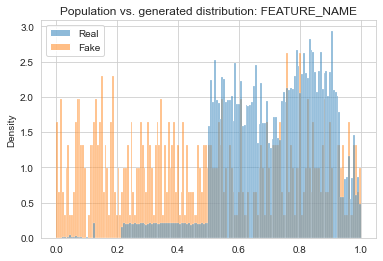

In [25]:
%%time
sns.histplot({"Real": src_ports, "Fake": src_ports_fake}, stat="density", element="bars", common_norm=False, kde=False, alpha=0.5)
plt.title("Population vs. generated distribution: FEATURE_NAME")

CPU times: user 1 s, sys: 94.8 ms, total: 1.1 s
Wall time: 1.24 s


Text(0.5, 1.0, 'Population vs. generated distribution: FEATURE_NAME')

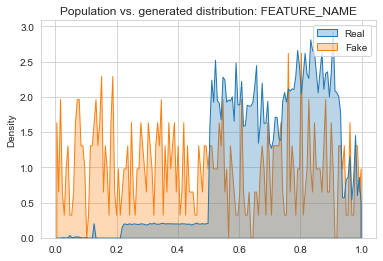

In [26]:
%%time
sns.histplot({"Real": src_ports, "Fake": src_ports_fake}, stat="density", element="poly", common_norm=False, kde=False, alpha=0.3)
plt.title("Population vs. generated distribution: FEATURE_NAME")

CPU times: user 3.07 s, sys: 149 ms, total: 3.22 s
Wall time: 3.16 s


Text(0.5, 1.0, 'Population vs. generated distribution: FEATURE_NAME')

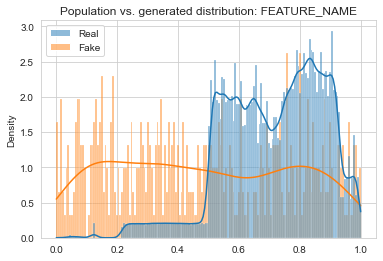

In [27]:
%%time
sns.histplot({"Real": src_ports, "Fake": src_ports_fake}, stat="density", common_norm=False, kde=True)
plt.title("Population vs. generated distribution: FEATURE_NAME")

CPU times: user 3.04 s, sys: 149 ms, total: 3.19 s
Wall time: 3.08 s


Text(0.5, 1.0, 'Population vs. generated distribution: FEATURE_NAME')

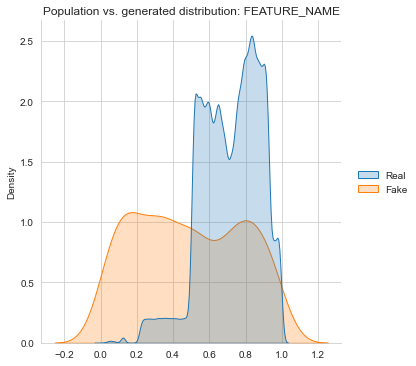

In [28]:
%%time
sns.displot({"Real": src_ports, "Fake": src_ports_fake}, kind="kde", common_norm=False, fill=True)
plt.title("Population vs. generated distribution: FEATURE_NAME")

### TensorBoard distribution logging

For evaluation during training, we can compare the distributions of the generated features with the actual distributions. 
Therefore, we write the relevant plots to TensorBoard.

However, it is not useful to generate the plots for every feature. Therefore, we select a few representative ones:
- `Source Port`
- `Destination Port` 
- `Flow Duration`
- `Flow Packets/s`
- `Fwd Packets/s`
- `Bwd Packets/s`
- `Average Packet Size`
- `Idle Mean`

We will have to create the plots many times. Therefore, using the whole train dataset for the ground truth distribution is slow. However, we can take the test dataset instead to avoid overhead. For example, creating the same plot as before with `Source Port` using the test dataset take 7 µs, instead of 3 seconds before. 

The distributions of train and test dataset should be (~) same anyway. To check this we plot the train against the testing distribution for a few features. 


In [31]:
train_dataset = CIC17Dataset("./data/cic-ids-2017_splits/seed_0/train_dataset_scaled.pt")
test_dataset = CIC17Dataset("./data/cic-ids-2017_splits/seed_0/test_dataset_scaled.pt")
column_names = torch.load("./data/cic-ids-2017_splits/seed_0/column_names.pt")
col_to_idx = {col: i for i, col in enumerate(column_names)}

CPU times: user 4 µs, sys: 11 µs, total: 15 µs
Wall time: 17.9 µs


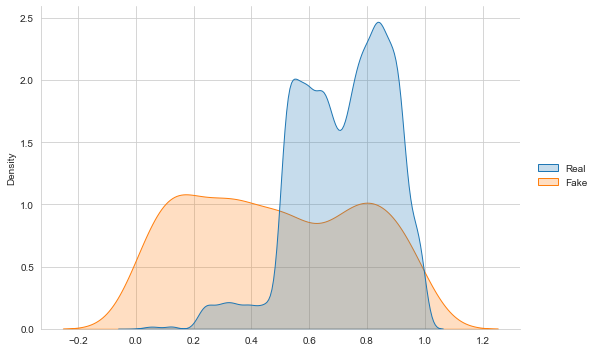

In [32]:
%time 
src_port_idx = col_to_idx["Source Port"]
sns.displot({"Real": test_dataset.X[:, src_port_idx], "Fake": src_ports_fake}, kind="kde", common_norm=False, fill=True, height=5, aspect=1.5)

CPU times: user 25.8 s, sys: 1.35 s, total: 27.1 s
Wall time: 26 s


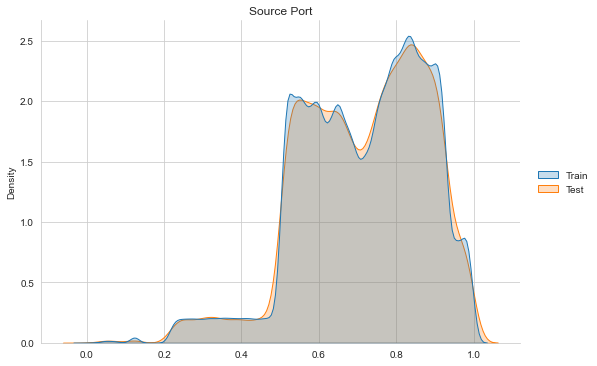

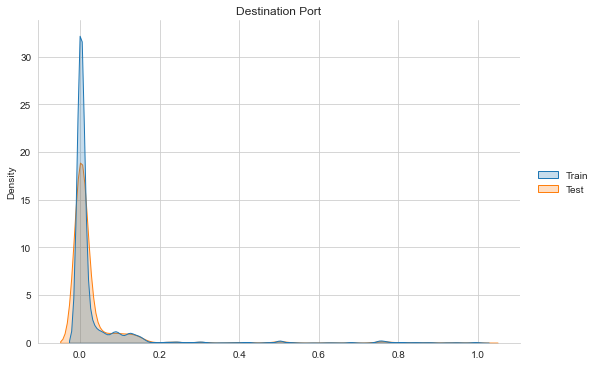

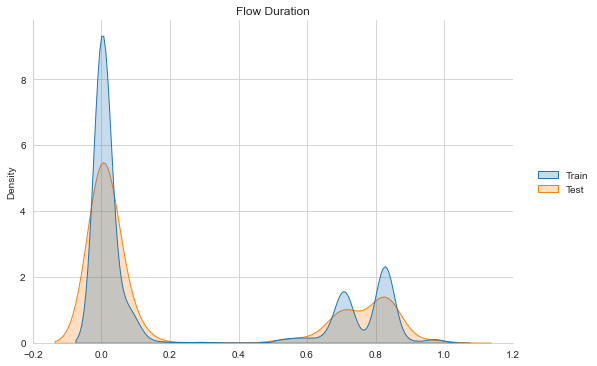

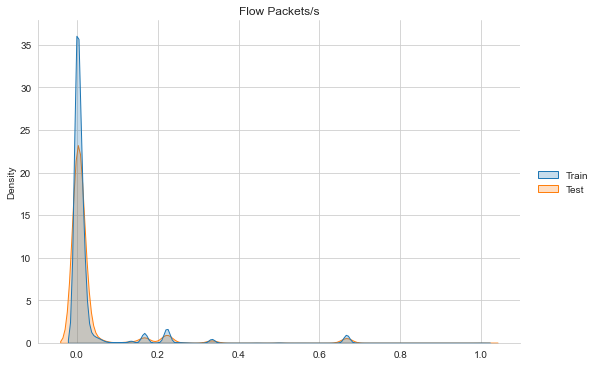

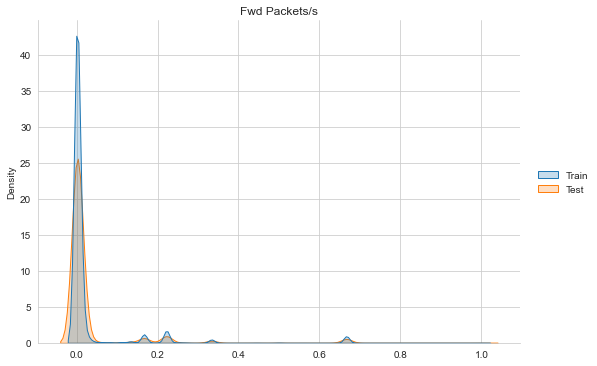

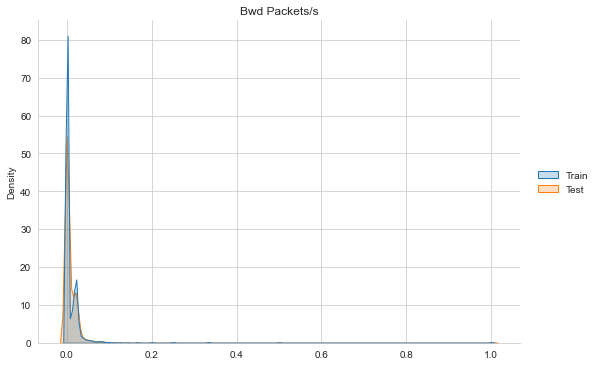

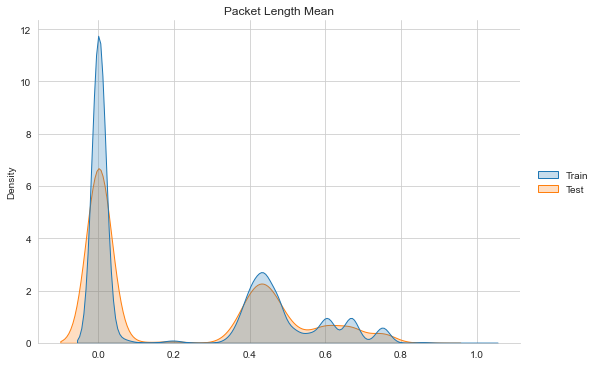

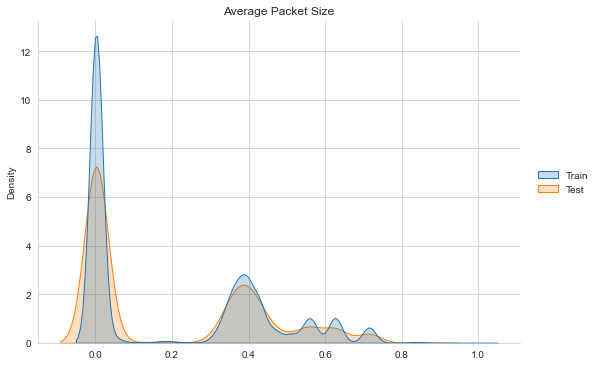

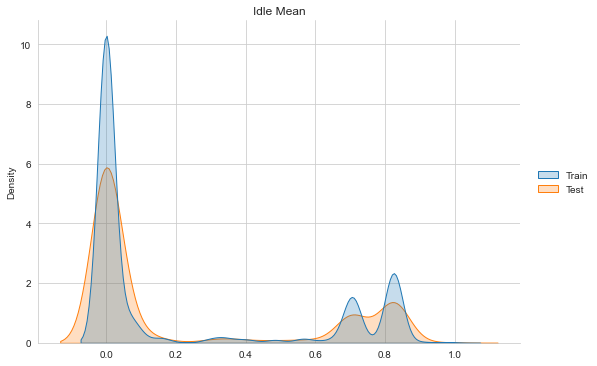

In [33]:
%%time
cols = ["Source Port", "Destination Port", "Flow Duration", "Flow Packets/s", "Fwd Packets/s", "Bwd Packets/s", "Packet Length Mean", "Average Packet Size", "Idle Mean"]
for col in cols:
    idx = col_to_idx[col]
    sns.displot({"Train": train_dataset.X[:, idx], "Test": test_dataset.X[:, idx]}, kind="kde", common_norm=False, fill=True, height=5, aspect=1.5)
    plt.title(col)

In [ ]:
%%time

def make_image(real, fake, feature_name):
    """
    Images cannot be written to TensorBoard directly. Easiest way is to write them to IOBuffer, then convert to PyTorch tensor. 
    
    """
    sns.displot({"Real": real, "Fake": fake}, kind="kde", common_norm=False, fill=True, height=5, aspect=1.5)
    plt.title(f"Population vs. generated distribution: {feature_name}")
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close("all")
    buf.seek(0)
    image = PIL.Image.open(buf)
    image = ToTensor()(image)
    return image

feature_name = "Src Ports"
src_ports = test_dataset.X[:, 0]
writer = SummaryWriter(log_dir="./test/test4")

for i in tqdm(range(10)):
    src_ports_fake = np.random.rand(500)
    image = make_image(src_ports, src_ports_fake, feature_name)
    writer.add_image(feature_name, image, i)
    writer.add_image(feature_name + "_test", image, i)

### Label distribution

During the generation process the generator generates fake flows. However, the discriminator takes flows & labels. 
Therefore, we also have to generate fake labels corresponding to the generated flows.

The problem is that the attack types (the labels) in our dataset are extremely imbalanced. Three attacks (DoS Hulk, PortScan, DDoS) make up 93% of all flows. 

Now, if we would sample the lables for the generated flows uniformly (i.e., equal probability for each label), this would can confuse the discriminator, as it sees a very different label distribution with the real flows. Since the dataset only contains a handful of flows for some attack types, it won't be able to classify those as fake/real very well. Therefore, the generator might get high reward for attack types that the discrimintaor rarely sees in the real training set. 

As a result, we have to assign class weights to the fake label generation process. To achieve this we could take the same distribution as in the train set, show below. However, some of the attack types would then occur only very rarely (e.g. only 0,1 % of all flows). Therefore, for all attack types that are below 1%, we assign a class weight of 1%. As a result we have to subtract a few percent from other classes, such that the total probabilities sum to 1. 



In [34]:
from collections import Counter

train_label_counts = Counter(train_dataset.y)
test_label_counts = Counter(test_dataset.y)
print({label: round(count / len(train_dataset), 6) for label, count in train_label_counts.most_common()})
print({label: round(count / len(test_dataset), 6) for label, count in test_label_counts.most_common()})

{3: 0.413479, 9: 0.285334, 1: 0.230031, 2: 0.018493, 6: 0.014257, 10: 0.010595, 5: 0.010414, 4: 0.00988, 0: 0.003514, 11: 0.002708, 13: 0.001171, 8: 6.4e-05, 12: 3.8e-05, 7: 2.1e-05}
{3: 0.413468, 9: 0.285324, 1: 0.23002, 2: 0.018507, 6: 0.014266, 10: 0.010601, 5: 0.010421, 4: 0.009882, 0: 0.003522, 11: 0.002695, 13: 0.001186, 8: 7.2e-05, 12: 3.6e-05}


In [35]:
label_weights = {0: 0.01,
                 1: 0.23,
                 2: 0.02,
                 3: 0.38,
                 4: 0.01,
                 5: 0.01,
                 6: 0.015,
                 7: 0.01,
                 8: 0.01,
                 9: 0.265,
                 10: 0.01,
                 11: 0.01,
                 12: 0.01,
                 13: 0.01}

In [36]:
fake_labels = np.random.choice(np.arange(0, 14), 64, p=list(label_weights.values()))
fake_labels

array([ 1,  9,  1, 10,  3,  9,  3,  1,  3,  3,  1,  1,  1,  3,  9,  9,  3,
        3,  3,  1,  3,  3,  3, 12,  9,  1,  9,  9,  3,  9,  9,  3,  3,  9,
        3,  9,  1,  3,  3,  0,  1,  3,  9,  3,  9, 12,  1,  1,  1, 10,  3,
        1,  0,  4,  9,  2,  9,  2,  1,  3,  3, 10,  9,  1])

### Euclidean distance per attack class

With pandas df could do simple groupby, but since we might scale the data it will be of type np.array. 

Therefore, have to concatenate scaled X array and y labels. Easiest way to do it is to create new pandas df. 

It makes most sense to do this on the scales features, since the indidvidual features have vastly different ranges (e.g., time vs. number of packets).

Not sure if this makes sense though. 

In [2]:
train_dataset = CIC17Dataset("./data/cic-ids-2017_splits/seed_0/train_dataset_scaled.pt")
test_dataset = CIC17Dataset("./data/cic-ids-2017_splits/seed_0/test_dataset_scaled.pt")
column_names = torch.load("./data/cic-ids-2017_splits/seed_0/column_names.pt")
X = train_dataset.X
y = train_dataset.y

In [3]:
df_mean = pd.DataFrame(np.append(X, y.reshape(-1, 1), axis=1), columns=column_names)
df_mean.Label = df_mean.Label.astype(int)
df_mean = df_mean.groupby("Label").mean()
df_mean

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.370702,0.273706,0.002978,0.000395,0.000602,9.104696e-04,0.000008,0.017152,0.001140,0.018970,0.016892,0.002950,0.001904,0.003298,0.003065,1.573792e-04,0.015891,0.000501,0.001054,0.001455,1.809432e-06,0.002934,0.001212,0.000305,0.001461,1.059954e-03,0.002972,0.001256,0.000366,0.001456,1.061360e-03,0.000000,0.0,0.0,0.0,0.000690,0.000643,0.007946,2.383696e-02,0.005811,0.017217,0.026345,0.020029,0.008752,0.000000,0.000000,0.0,0.622174,0.377826,0.364370,0.0,0.0,0.109795,0.023656,0.018970,0.003298,0.000690,0.0,0.0,0.0,0.0,0.0,0.0,0.000395,9.104696e-04,0.000602,0.000008,0.083357,0.036278,3.020504e-04,0.501027,0.000002,9.020484e-07,0.000003,0.000002,0.000091,3.569324e-07,0.000091,0.000090
1,0.703117,0.001235,0.141281,0.000629,0.000590,1.113433e-05,0.000936,0.000638,0.001100,0.001246,0.000812,0.265128,0.000280,0.255489,0.256696,3.103738e-05,0.000057,0.015665,0.061040,0.131947,1.968226e-05,0.137614,0.022110,0.073255,0.129353,2.139071e-05,0.003704,0.000933,0.002814,0.003667,6.514638e-07,0.000000,0.0,0.0,0.0,0.000879,0.000659,0.000034,7.050134e-05,0.005609,0.197305,0.380779,0.333660,0.190112,0.000206,0.000000,0.0,0.454992,0.546331,0.000016,0.0,0.0,0.104132,0.354230,0.001246,0.255489,0.000879,0.0,0.0,0.0,0.0,0.0,0.0,0.000629,1.113433e-05,0.000590,0.000936,0.060640,0.005018,5.957138e-04,0.454545,0.005845,0.000000e+00,0.004728,0.007652,0.099825,6.255840e-02,0.126256,0.073395
2,0.626118,0.001223,0.192807,0.000888,0.000673,1.459470e-04,0.000833,0.013428,0.000000,0.010019,0.018246,0.241921,0.000103,0.216660,0.238049,3.475873e-07,0.000003,0.115318,0.049657,0.163674,9.441312e-02,0.163594,0.130334,0.020672,0.159770,1.239985e-01,0.066964,0.017099,0.031057,0.040329,3.295012e-04,0.000000,0.0,0.0,0.0,0.001772,0.001125,0.000003,3.672156e-07,0.000000,0.180568,0.258916,0.268753,0.114412,0.000000,0.000000,0.0,0.716097,0.286255,0.007159,0.0,0.0,0.010977,0.233327,0.010019,0.216660,0.001772,0.0,0.0,0.0,0.0,0.0,0.0,0.000888,1.459470e-04,0.000673,0.000833,0.327133,0.005786,1.806678e-04,0.727310,0.006050,9.022410e-04,0.005287,0.007284,0.156310,7.127837e-04,0.156773,0.155945
3,0.718086,0.001223,0.477650,0.000777,0.000765,9.859147e-05,0.000990,0.010012,0.000105,0.007511,0.013692,0.231608,0.000011,0.221943,0.200898,1.477180e-05,0.060656,0.039991,0.196085,0.474396,6.706144e-06,0.477033,0.084468,0.283616,0.474302,8.465369e-06,0.153904,0.026864,0.097938,0.153538,3.438832e-04,0.000000,0.0,0.0,0.0,0.001504,0.001272,0.060516,4.200303e-04,0.000010,0.172288,0.306998,0.258495,0.104846,0.256333,0.000000,0.0,0.063691,0.680927,0.000682,0.0,0.0,0.064184,0.276694,0.007511,0.221943,0.001504,0.0,0.0,0.

In [4]:
# how to compute distance now? 
num_samples = 1024
num_labels = 14

# make "fake" flows
indices = np.random.randint(train_dataset.X.shape[0], size=num_samples)
X_pred = train_dataset.X[indices]
y_pred = train_dataset.y[indices]
random_flows = pd.DataFrame(np.append(X_pred, y_pred.reshape(-1, 1), axis=1), columns=column_names)

# probably have to do this in a loop
distances = []
for label in range(num_labels):
    generated_by_class = random_flows[random_flows.Label == label].drop("Label", axis=1)
    mean_by_class = df_mean.loc[label]
    distance_by_feature = np.linalg.norm(generated_by_class - mean_by_class, axis=0)
    distances.append(distance_by_feature)
    
    
distances = pd.DataFrame(distances, columns=column_names[:-1], index=range(0, num_labels))
distances.index.name = "Label"
distances

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.631002,6.037408e-01,0.005388,0.000597,0.000601,0.001748,0.000016,0.026957,0.003116,0.029266,0.024361,0.007251,0.003125,0.007001,0.009214,2.870353e-04,0.030739,0.000907,0.001801,0.002397,2.517256e-06,0.005301,0.002233,0.000511,0.002402,0.002119,0.005386,0.002236,0.000649,0.002400,2.117809e-03,0.000000,0.0,0.0,0.0,0.000748,0.000654,0.015367,0.046115,0.015886,0.027081,0.033452,0.028908,0.017251,0.000000,0.000000,0.0,1.029420,1.029420,1.036138,0.0,0.0,0.174868,0.028243,0.029266,0.007001,0.000748,0.0,0.0,0.0,0.0,0.0,0.0,0.000597,0.001748,0.000601,0.000016,0.128812,0.055609,0.000547,9.296409e-02,0.000004,0.000002,0.000005,0.000004,0.000181,7.138648e-07,0.000181,0.000180
1,3.165591,1.722343e-04,3.897966,0.005336,0.006662,0.000065,0.010306,0.004195,0.021180,0.003026,0.009596,3.324852,0.004150,2.939828,3.353826,9.836863e-04,0.000798,0.321597,1.441121,3.542076,2.866900e-04,3.893717,0.540660,1.880169,3.564102,0.000302,0.073183,0.019922,0.057573,0.072951,3.413716e-05,0.000000,0.0,0.0,0.0,0.005385,0.007398,0.000458,0.001115,0.107969,2.471576,4.358322,4.036099,2.909881,0.003049,0.000000,0.0,7.391584,7.391772,0.000244,0.0,0.0,1.866650,4.091342,0.003026,2.939828,0.005385,0.0,0.0,0.0,0.0,0.0,0.0,0.005336,0.000065,0.006662,0.010306,0.913088,0.055130,0.004368,1.313182e-11,0.293714,0.000000,0.237604,0.384519,2.698482,3.202911e+00,3.588406,2.312414
2,0.454942,5.349750e-16,0.857151,0.002386,0.001980,0.000829,0.002871,0.040420,0.000000,0.045335,0.057901,0.905520,0.000449,0.753485,0.896316,1.211377e-06,0.000143,1.014855,0.160575,0.926145,1.047588e+00,0.927159,1.002636,0.074400,0.934949,1.019120,0.217588,0.066672,0.099748,0.130399,9.340202e-03,0.000000,0.0,0.0,0.0,0.004033,0.003315,0.000143,0.000001,0.000000,0.674362,0.854138,0.965471,0.586151,0.000000,0.000000,0.0,2.233601,2.230878,0.993306,0.0,0.0,0.047848,0.768884,0.045335,0.753485,0.004033,0.0,0.0,0.0,0.0,0.0,0.0,0.002386,0.000829,0.001980,0.002871,1.002958,0.018050,0.001131,1.621041e-04,0.056269,0.003933,0.045733,0.073424,0.948915,3.106952e-03,0.948652,0.949125
3,2.629441,9.028763e-14,7.757785,0.009457,0.010416,0.002080,0.013782,0.140712,0.011509,0.137011,0.199507,3.675584,0.000220,3.245081,3.362992,4.004464e-03,2.939842,0.675509,3.204665,7.690032,1.321224e-04,7.752229,1.474044,4.675381,7.690921,0.000260,6.292355,1.111362,4.046449,6.283909,7.022434e-03,0.000000,0.0,0.0,0.0,0.015535,0.017317,2.939786,0.010188,0.000206,2.733659,4.406376,3.973189,2.162574,8.858704,0.000000,0.0,4.940039,9.454201,0.014017,0.0,0.0,1.848725,3.995966,0.137011,3.245081,0.015535,0.0,0.0,0.0,0.0,0.0,0.0,0.009457,0.002080,0.010416,0.013782,2.2295

In [5]:
# mean distance per class
distances.mean(axis=1)

Label
0     0.066037
1     1.056460
2     0.327537
3     1.950912
4     0.301866
5     0.361031
6     0.143182
7     0.000000
8     0.000000
9     0.291750
10    0.115140
11    0.000000
12    0.000000
13    0.008770
dtype: float64

In [10]:
# this seems to be problematic though, since the euclidean distance between mean flow and the dataset it is constructed from can be pretty big

num_samples = 1024
num_labels = 14

# make "fake" flows
X_pred = train_dataset.X
y_pred = train_dataset.y
flows = pd.DataFrame(np.append(X_pred, y_pred.reshape(-1, 1), axis=1), columns=column_names)

# probably have to do this in a loop
distances = []
for label in range(num_labels):
    generated_by_class = flows[flows.Label == label].drop("Label", axis=1)
    mean_by_class = df_mean.loc[label]
    distance_by_feature = np.linalg.norm(generated_by_class - mean_by_class, axis=0)
    distances.append(distance_by_feature)
    
    
distances = pd.DataFrame(distances, columns=column_names[:-1], index=range(0, num_labels))
distances.index.name = "Label"
distances

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,14.853281,1.269700e+01,0.726492,0.031065,0.058674,0.272229,0.000443,4.178858,0.063199,4.376783,3.439434,0.147001,0.062997,0.133576,0.177487,2.025177e-02,2.206304,0.049719,0.099474,0.138839,6.437101e-04,0.674019,0.107969,0.087931,0.139343,7.861793e-02,0.726436,0.112439,0.089069,0.139885,7.856823e-02,0.000000,0.0,0.0,0.0,0.032390,0.059361,1.103153e+00,3.309454,0.322168,4.178367,4.678285,3.939971,2.768530,0.000000,0.000000,0.0,20.898957,20.898957,20.744187,0.0,0.0,3.478753,3.950129,4.376783,0.133576,0.032390,0.0,0.0,0.0,0.0,0.0,0.0,0.031065,0.272229,0.058674,0.000443,2.685107,5.348861,0.031924,3.433263e+00,0.002546,0.001185,0.003448,0.002745,0.118971,0.000518,0.118971,0.118363
1,81.879971,1.076768e+00,90.135716,0.119878,0.161214,0.001455,0.247007,0.100559,0.507599,0.072634,0.231104,79.564221,4.809579,70.004024,79.510540,2.655016e-01,1.172349,7.433847,33.675465,83.308864,5.622956e-01,89.875193,12.487933,44.292399,83.782761,5.623408e-01,1.709791,0.444867,1.320814,1.705140,2.011503e-03,0.000000,0.0,0.0,0.0,0.120888,0.178819,7.444313e-01,1.388388,2.587579,59.144885,105.227598,97.972147,70.840417,4.999486,0.000000,0.0,173.665277,173.622933,1.414202,0.0,0.0,44.372749,98.836156,0.072634,70.004024,0.120888,0.0,0.0,0.0,0.0,0.0,0.0,0.119878,0.001455,0.161214,0.247007,22.012674,1.320836,0.098446,3.087616e-10,7.965978,0.000000,6.444176,10.428743,67.906755,68.626111,84.293726,61.632461
2,10.868975,1.213617e-14,22.557653,0.053805,0.043329,0.018061,0.065263,0.840968,0.000000,0.938086,1.230606,19.592893,0.054266,16.625607,19.233082,3.157783e-05,0.003780,21.780720,15.498075,23.574676,2.130254e+01,23.834595,25.050422,1.827456,23.797101,2.534783e+01,5.520553,1.646244,2.448051,3.431088,6.293318e-01,0.000000,0.0,0.0,0.0,0.089858,0.072811,3.780860e-03,0.000031,0.000000,14.502891,18.308841,20.322268,12.155475,0.000000,0.000000,0.0,44.585718,44.696450,8.336599,0.0,0.0,4.087871,16.350115,0.938086,16.625607,0.089858,0.0,0.0,0.0,0.0,0.0,0.0,0.053805,0.018061,0.043329,0.065263,20.009095,0.360624,0.021222,2.571034e-01,2.615332,1.282728,2.343161,3.271043,23.965646,0.946607,23.971491,23.975956
3,58.128111,2.052584e-12,179.097344,0.216898,0.246942,0.043452,0.322582,3.285309,0.258591,3.110894,4.685183,84.114252,1.265062,74.734899,75.665642,7.623913e-02,69.418699,15.741182,74.020170,177.682308,9.776632e-01,178.978167,34.344027,108.443232,177.731577,9.776752e-01,145.349683,26.018821,92.962229,145.111584,5.943887e+00,0.000000,0.0,0.0,0.0,0.355580,0.410372,6.931789e+01,5.638207,0.183740,62.561190,103.235066,91.245906,46.963429,204.142982,0.000000,0.0,114.180412,217.940577,12.202395,0.0,0.0

In [7]:
# mean distance per class
distances.mean(axis=1)

Label
0      1.937997
1     25.412618
2      7.495972
3     45.437780
4      7.729292
5      8.047601
6      3.079600
7      0.135283
8      0.704329
9      6.673569
10     2.217178
11     1.041709
12     0.148320
13     0.536338
dtype: float64

### Statistical tests

Candidate tests:
- Kolmogorov smirnov test
- ttest
- Wilcoxon test
- maximum mean discrepancy

Evaluation similar to this would make sense: https://www.quantmetry.com/blog/tabular-data-generation-using-generative-adversarial-networks/

This has to be done for each attack type. Question is how to best write this to TensorBoard. Just keep the number of different columns? 

In [127]:
x = np.random.normal(0, 1, 100000)
y = np.random.normal(0, 1, 1000)
z = np.random.normal(1.1, 0.9, 1000)

# Kolmogorov-Smirnov test
print(scipy.stats.ks_2samp(x, y), scipy.stats.ks_2samp(x, z))

# two sample ttes
print(scipy.stats.ttest_ind(x, y), scipy.stats.ttest_ind(x, z))

# two-sample wilcoxon ranksum test
print(scipy.stats.ranksums(x, y), scipy.stats.ranksums(x, z))

KstestResult(statistic=0.028719999999999968, pvalue=0.3805448281126407) KstestResult(statistic=0.46204, pvalue=5.652313559948535e-194)
Ttest_indResult(statistic=-0.47559958830033117, pvalue=0.634360697361632) Ttest_indResult(statistic=-35.99896022008747, pvalue=5.390264831789379e-282)
RanksumsResult(statistic=-0.4983211381472683, pvalue=0.6182577112903457) RanksumsResult(statistic=-32.909191227033254, pvalue=1.6237996473835788e-237)


In [33]:
%%time
# conduct tests between training and testing dataset
# there should not be any significant difference between the columns
# can implement this similarly in evaluation script 

df_stats = []
for col in range(len(column_names) - 1):
    train_vals, test_vals = train_dataset.X[:, col], test_dataset.X[:, col]
    ks_test = scipy.stats.ks_2samp(train_vals, test_vals)
    t_test = scipy.stats.ttest_ind(train_vals, test_vals)
    wr_test = scipy.stats.ranksums(train_vals, test_vals)
    stats = [column_names[col], ks_test[0], ks_test[1], ks_test[1] < 0.05,
             t_test[0], t_test[1], t_test[1] < 0.05,
             wr_test[0], wr_test[1], wr_test[1] < 0.05]
    df_stats.append(stats)
    
df_stats = pd.DataFrame(df_stats, columns=["feature_col", "ks_stat", "ks_p", "ks_different","t_stat",
                                           "t_p", "t_different", "wr_stat", "wr_p", "wr_different"])
df_stats = df_stats.set_index("feature_col")

CPU times: user 13 s, sys: 585 ms, total: 13.6 s
Wall time: 15.9 s


In [34]:
%%time
# second trial, smaller train dataset (to check time consumption and acc)
indices = np.random.randint(train_dataset.X.shape[0], size=1024)
train_sample = train_dataset.X[indices]
df_stats_small = []
for col in range(len(column_names) - 1):
    # difference
    train_vals, test_vals = train_sample[:, col], test_dataset.X[:, col]
    ks_test = scipy.stats.ks_2samp(train_vals, test_vals)
    t_test = scipy.stats.ttest_ind(train_vals, test_vals)
    wr_test = scipy.stats.ranksums(train_vals, test_vals)
    stats = [column_names[col], ks_test[0], ks_test[1], ks_test[1] < 0.05,
             t_test[0], t_test[1], t_test[1] < 0.05,
             wr_test[0], wr_test[1], wr_test[1] < 0.05]
    df_stats_small.append(stats)
    
df_stats_small = pd.DataFrame(df_stats_small, columns=["feature_col", "ks_stat", "ks_p", "ks_different","t_stat",
                                                       "t_p", "t_different", "wr_stat", "wr_p", "wr_different"])
df_stats_small = df_stats_small.set_index("feature_col")
df_stats_small

CPU times: user 544 ms, sys: 12.9 ms, total: 557 ms
Wall time: 629 ms


,ks_stat,ks_p,ks_different,t_stat,t_p,t_different,wr_stat,wr_p,wr_different
feature_col,,,,,,,,,
Source Port,0.019750,0.828126,False,-0.332886,0.739223,False,-0.171865,0.863544,False
Destination Port,0.029228,0.360498,False,-1.029980,0.303028,False,-2.042077,0.041144,True
Flow Duration,0.022539,0.688385,False,-0.503382,0.614700,False,0.312437,0.754709,False
Total Fwd Packets,0.017774,0.908229,False,-0.098198,0.921776,False,0.358229,0.720172,False
Total Backward Packets,0.015032,0.976471,False,0.058624,0.953252,False,0.515873,0.605943,False
...,...,...,...,...,...,...,...,...,...
Active Min,0.013794,0.990596,False,-1.947804,0.051448,False,-0.397222,0.691204,False
Idle Mean,0.018384,0.885898,False,-0.664275,0.506520,False,-0.129913,0.896635,False
Idle Std,0.007512,1.000000,False,0.789737,0.429688,False,0.308454,0.757737,False


In [35]:
# Kolmogorov-Smirnov and t-test seem to be most robust for whole dataset
df_stats.describe(include="bool")

,ks_different,t_different,wr_different
count,79,79,79
unique,2,2,2
top,False,False,False
freq,73,73,61


In [36]:
# similar performance on sample
# can be computed quickly, could take all three tests
# but then it becomes cluttered
# take the ks test? 
df_stats_small.describe(include="bool")

,ks_different,t_different,wr_different
count,79,79,79
unique,1,2,2
top,False,False,False
freq,79,78,77


In [150]:
%%time

# simplified version, comparing train vs test dataset only with Kolmogorov-Smirnov test
# but for each class separately
num_labels = 14
stats = []
for label in range(num_labels):
    X_train_by_class =  train_dataset.X[np.where(train_dataset.y == label)]
    X_test_by_class = test_dataset.X[np.where(test_dataset.y == label)]
    
    is_different = []
    for col in range(len(column_names) - 1):
        train_vals, test_vals = X_train_by_class[:, col], X_test_by_class[:, col]
        if train_vals.size == 0 or test_vals.size == 0:
            is_different.append(None)
        else:
            ks_test = scipy.stats.ks_2samp(train_vals, test_vals)
            is_different.append(ks_test[1] < 0.05)
        
    stats.append(is_different)
    
class_names = torch.load("./data/cic-ids-2017_splits/seed_0/class_names.pt")
df_is_different = pd.DataFrame(stats, columns=column_names[:-1], index=class_names[:-1])
df_is_different

CPU times: user 22.8 s, sys: 438 ms, total: 23.2 s
Wall time: 25.2 s


,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Bot,False,False,False,True,False,True,True,True,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False
DDoS,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
DoS GoldenEye,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
DoS Hulk,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
DoS Slowhttptest,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
DoS slowloris,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [162]:
# number of "real" feature per attack type
(df_is_different == False).sum(axis=1).to_dict()

{'Bot': 54,
 'DDoS': 78,
 'DoS GoldenEye': 79,
 'DoS Hulk': 73,
 'DoS Slowhttptest': 79,
 'DoS slowloris': 79,
 'FTP-Patator': 79,
 'Heartbleed': 0,
 'Infiltration': 78,
 'PortScan': 79,
 'SSH-Patator': 79,
 'Web Attack \x96 Brute Force': 79,
 'Web Attack \x96 Sql Injection': 79,
 'Web Attack \x96 XSS': 79}

### Validate classifier predictions (only class condition)

- load pretrained GAN
- generate flows

In [6]:
# import torch
# import joblib
# import pandas as pd

# from collections import Counter
# from scikitplot.metrics import plot_confusion_matrix
# from sklearn.metrics import classification_report

# from networks import Generator, Discriminator
# from experiment import CGANExperiment
# from cic_ids_17_dataset import CIC17Dataset


# G, D = Generator(79, 14), Discriminator(79, 14)
# exp = CGANExperiment(G, D, None, None)
# exp.load_model("./models/cgan/20-05-2021_12h09m/model-100.pt", load_optimizer=False)

# classifier = joblib.load("./models/classifier/20-05-2021_12h01m/classifier.gz")
# scaler = joblib.load("./data/cic-ids-2017_splits/seed_0/min_max_scaler.gz")
# label_encoder = joblib.load("./data/cic-ids-2017_splits/seed_0/label_encoder.gz")

# label_distribution = {0: 0.01, 1: 0.23, 2: 0.02, 3: 0.38, 4: 0.01, 5: 0.01, 6: 0.015,
#                       7: 0.01, 8: 0.01, 9: 0.265, 10: 0.01, 11: 0.01, 12: 0.01, 13: 0.01}
# label_weights = list(label_distribution.values())

In [7]:
# # generate 10000 flows and predict
# flows, labels = exp.generate(10000, label_weights, scaler=scaler, label_encoder=label_encoder)
# label_preds = label_encoder.inverse_transform(classifier.predict(flows))
# print(classification_report(labels, label_preds))
# plot_confusion_matrix(labels, label_preds, x_tick_rotation=90)

In [56]:
test_dataset = CIC17Dataset("./data/cic-ids-2017_splits/seed_0/test_dataset.pt")
df_test = pd.DataFrame(test_dataset.X, columns=test_dataset.column_names[:-1])
df_test["Label"] = label_encoder.inverse_transform(test_dataset.y)

df_gen = pd.DataFrame(flows, columns=test_dataset.column_names[:-1])
df_gen["Label"] = labels

/Users/thomas/anaconda3/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [57]:
df_test[df_test.Label == "DoS Hulk"].head()

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
3,36408.0,80.0,97839047.0,4.0,7.0,378.0,11595.0,372.0,0.0,94.5,185.02162,4344.0,0.0,1656.428571,1757.579003,122.374454,0.112430,9783904.700,30900000.0,97800000.0,4.0,97800000.0,32600000.0,56500000.0,97800000.0,4.0,39612.0,6602.0,10634.89650,25103.0,48.0,0.0,0.0,0.0,0.0,124.0,232.0,0.040883,0.071546,0.0,4344.0,998.250000,1535.081054,2356473.841,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1089.000000,94.5,1656.428571,124.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,378.0,7.0,11595.0,0.0,235.0,1.0,20.0,0.0,0.0,0.0,0.0,97800000.0,0.0,97800000.0,97800000.0,DoS Hulk
5,38874.0,80.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,500000.000000,4.000,0.0,4.0,4.0,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,500000.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,251.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS Hulk
6,57996.0,80.0,98704714.0,7.0,5.0,329.0,11595.0,323.0,0.0,47.0,121.72510,7240.0,0.0,2319.000000,3331.638186,120.804767,0.121575,8973155.818,29700000.0,98600000.0,1.0,98700000.0,16400000.0,40300000.0,98600000.0,1.0,62476.0,15619.0,24290.23816,51223.0,46.0,0.0,0.0,0.0,0.0,220.0,168.0,0.070919,0.050656,0.0,7240.0,917.230769,2244.537115,5037946.859,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,993.666667,47.0,2319.000000,220.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,329.0,5.0,11595.0,251.0,235.0,2.0,20.0,3.0,0.0,3.0,3.0,98600000.0,0.0,98600000.0,98600000.0,DoS Hulk
7,53406.0,80.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,500000.000000,4.000,0.0,4.0,4.0,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,500000.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,274.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS Hulk
12,45162.0,80.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,500000.000000,4.000,0.0,4.0,4.0,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,500000.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,251.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS Hulk


In [58]:
df_gen[df_gen.Label == "DoS Hulk"].head()

,Source Port,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2,32050.811232,30.591527,2772.266063,1.806631,0.001131,0.020014,0.060006,0.114976,0.001437,0.015052,0.000973,0.003810,0.000888,0.002964,0.000927,174.756084,660891.262811,455.764242,486.780806,780.834202,-12.792128,1852.654023,153.152555,306.705129,526.804033,-4.953362,3.257840,0.087602,0.815912,1.291593,10.667874,1.242319e-12,1.207061e-12,9.938313e-13,9.401889e-13,28.075586,0.044019,639885.051270,574.570906,0.000813,0.039355,0.018031,0.028145,1.775505,3.447713e-11,1.696845e-11,1.073078e-12,1.451672e-06,1.0,2.805866e-10,1.091631e-12,9.418923e-13,0.000326,0.046208,0.003707,0.001871,44.640114,9.986902e-13,1.159257e-12,1.006801e-12,1.033583e-12,1.035060e-12,1.029486e-12,1.501964,0.029880,0.000170,0.088472,168.564072,-0.999926,0.002149,32.076135,0.024118,1.505858e-03,0.000979,0.001622,16.389704,0.136129,21.939650,40.255785,DoS Hulk
10,33609.909426,18.341330,3087.095160,1.769576,0.001027,0.017706,0.066999,0.089240,0.001610,0.007389,0.000808,0.005446,0.000456,0.003749,0.000923,91.106379,653326.405251,353.211303,509.134255,833.332637,-12.924834,1636.262314,164.113558,341.030274,673.644663,-7.022258,3.597897,0.138034,1.087849,1.620728,10.003150,1.121742e-12,1.033616e-12,7.723258e-13,8.758343e-13,40.567396,0.031244,636003.760737,590.610201,0.001229,0.052482,0.020841,0.021887,0.998517,2.583991e-11,4.584958e-12,8.931359e-13,1.039501e-07,1.0,5.577598e-10,1.022919e-12,8.250458e-13,0.000172,0.048769,0.002120,0.002152,31.464099,9.768104e-13,9.457951e-13,8.406718e-13,8.652988e-13,9.714889e-13,8.634112e-13,1.515773,0.023201,0.000108,0.047005,103.608253,-0.999918,0.001590,32.301779,0.007979,1.022548e-03,0.000383,0.000649,17.117883,0.150103,21.949737,42.942390,DoS Hulk
12,35283.299472,17.771876,3582.666625,1.800647,0.001132,0.019793,0.071107,0.098473,0.001603,0.007228,0.000872,0.005840,0.000456,0.004016,0.001009,91.449713,647767.482395,407.884394,598.137435,1009.843675,-12.920786,1880.754135,199.263322,410.458594,832.575533,-7.210157,4.380727,0.173503,1.368801,1.993766,10.810580,1.301512e-12,1.082083e-12,7.980817e-13,9.227868e-13,44.516684,0.033253,630489.451957,611.157389,0.001255,0.056621,0.022312,0.021704,1.043101,2.461456e-11,3.510906e-12,9.356432e-13,1.390572e-07,1.0,3.546189e-10,1.089357e-12,8.703987e-13,0.000161,0.049726,0.002079,0.002366,31.596306,1.054763e-12,9.759128e-13,8.727128e-13,8.978757e-13,1.035200e-12,8.960195e-13,1.541114,0.026963,0.000108,0.044271,114.172755,-0.999891,0.001706,32.181978,0.007944,1.073294e-03,0.000431,0.000701,28.320219,0.167390,36.299534,69.097441,DoS Hulk
13,39124.947794,13.738538,3033.305584,1.702703,0.000731,0.012289,0.048868,0.075535,0.001150,0.004099,0.000520,0.003797,0.000270,0.002612,0.000600,50.954695,665

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
/Users/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score ar

                            precision    recall  f1-score   support

                       Bot       1.00      0.86      0.92       106
                      DDoS       0.96      0.99      0.97      2372
             DoS GoldenEye       1.00      1.00      1.00       211
                  DoS Hulk       0.95      0.66      0.78      3706
          DoS Slowhttptest       0.88      0.06      0.11       120
             DoS slowloris       0.49      0.61      0.54        87
               FTP-Patator       0.53      1.00      0.69       146
                Heartbleed       1.00      0.02      0.04       103
              Infiltration       0.00      0.00      0.00       104
                  PortScan       0.95      1.00      0.98      2640
               SSH-Patator       0.07      1.00      0.13        96
  Web Attack  Brute Force       0.63      0.85      0.73       103
Web Attack  Sql Injection       0.00      0.00      0.00       103
          Web Attack  XSS       0.00      0.00

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


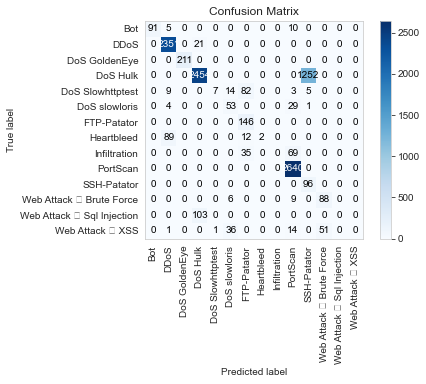

In [64]:
# generate 10000 flows
# round all int cols
# is_int_col = [t == int for t in df.dtypes.values]
is_int_col = [True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, 
              False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True,
              True, True, True, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False,
              False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False,
              False, False, False, False, False, False, True]


flows, labels = exp.generate(10000, label_weights, scaler=scaler, label_encoder=label_encoder)
flows = pd.DataFrame(flows)
flows.loc[:, is_int_col[:-1]] = flows.loc[:, is_int_col[:-1]].round(0)
flows = flows.to_numpy()

label_preds = classifier.predict(flows)
label_preds = label_encoder.inverse_transform(label_preds)

print(classification_report(labels, label_preds))
plot_confusion_matrix(labels, label_preds, x_tick_rotation=90)

## Make dynamic condition vectors

For each flow we want to discretize the selected features into low/mid/high buckets based on its feature value. 

In pandas this can be achieved used [`pd.qcut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html#pandas.qcut), as discussed [here](https://stackoverflow.com/questions/54369807/how-can-i-categorize-all-columns-in-a-data-at-once-make-all-values-become-high).


In [87]:
condition_vector_features = ['Destination Port', 'Flow Duration', 'Total Backward Packets', 'Total Fwd Packets',
                             'Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Min', 'Flow IAT Max', 'PSH Flag Count',
                             'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count']
flag_cols = [col for col in condition_vector_features if "Flag" in col]
cols_to_dummy = [col for col in condition_vector_features if col not in flag_cols and col != "Destination Port"]

df_condition = df[condition_vector_features]
df_condition

,Destination Port,Flow Duration,Total Backward Packets,Total Fwd Packets,Packet Length Mean,Flow Bytes/s,Flow IAT Min,Flow IAT Max,PSH Flag Count,SYN Flag Count,RST Flag Count,ACK Flag Count
0,444,42664070,6,5,36.000000,10.125616,29.0,42400000.0,1,0,0,0
1,444,2030,0,2,6.000000,5911.330049,2030.0,2030.0,0,0,0,1
2,444,119991834,5525,5523,262.423387,24164.277710,3.0,9432176.0,1,0,0,0
3,444,5005212,15,15,2.903226,17.981256,297.0,513363.0,1,0,0,0
4,444,119973135,4374,4376,268.281111,19568.730950,1.0,1163091.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
557641,80,5005388,3,5,291.111111,523.435945,4.0,5000145.0,1,0,0,0
557642,80,5016759,5,5,431.636364,946.427763,4.0,5004049.0,1,0,0,0
557643,80,5009163,4,4,291.111111,523.041474,56.0,5003805.0,1,0,0,0
557644,80,73,1,1,0.000000,0.000000,73.0,73.0,0,0,0,1


In [88]:
# it does not make sense to quantile encode the Flags, they are binary already
df_condition["PSH Flag Count"].value_counts(), df_condition["SYN Flag Count"].value_counts(), \
df_condition["RST Flag Count"].value_counts(), df_condition["ACK Flag Count"].value_counts()

(0    299399
 1    257157
 Name: PSH Flag Count, dtype: int64,
 0    549843
 1      6713
 Name: SYN Flag Count, dtype: int64,
 0    556556
 Name: RST Flag Count, dtype: int64,
 0    315694
 1    240862
 Name: ACK Flag Count, dtype: int64)

In [89]:
quantiles = [0, 0.33, 0.66, 1.0]
df_condition.loc[:, cols_to_dummy] = df_condition.loc[:, cols_to_dummy].apply(lambda x: pd.qcut(x, q=quantiles, labels=False))

df_condition = pd.get_dummies(df_condition, columns=cols_to_dummy)
reorder_cols = [col for col in df_condition.columns if col not in flag_cols] + flag_cols
df_condition = df_condition[reorder_cols]
df_condition

/Users/thomas/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


,Destination Port,Flow Duration_0,Flow Duration_1,Flow Duration_2,Total Backward Packets_0,Total Backward Packets_1,Total Backward Packets_2,Total Fwd Packets_0,Total Fwd Packets_1,Total Fwd Packets_2,Packet Length Mean_0,Packet Length Mean_1,Packet Length Mean_2,Flow Bytes/s_0,Flow Bytes/s_1,Flow Bytes/s_2,Flow IAT Min_0,Flow IAT Min_1,Flow IAT Min_2,Flow IAT Max_0,Flow IAT Max_1,Flow IAT Max_2,PSH Flag Count,SYN Flag Count,RST Flag Count,ACK Flag Count
0,444,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0
1,444,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,444,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0
3,444,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0
4,444,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557641,80,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
557642,80,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
557643,80,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
557644,80,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1


In [90]:
from cic_ids_17_dataset import convert_port_to_binary


port_col = "Destination Port"

# covert port to 16 bit array and add to df
df_condition[port_col] = df_condition[port_col].apply(convert_port_to_binary)

# make new port df to separate arrays into columns
df_port = pd.DataFrame(df_condition[port_col].tolist(), columns=[port_col + f"_{i}" for i in range(16)], index=df_condition.index)

# concantenate dfs
df_condition = pd.concat([df_port, df_condition.drop(port_col, axis=1)], axis=1)
df_condition

,Destination Port_0,Destination Port_1,Destination Port_2,Destination Port_3,Destination Port_4,Destination Port_5,Destination Port_6,Destination Port_7,Destination Port_8,Destination Port_9,Destination Port_10,Destination Port_11,Destination Port_12,Destination Port_13,Destination Port_14,Destination Port_15,Flow Duration_0,Flow Duration_1,Flow Duration_2,Total Backward Packets_0,Total Backward Packets_1,Total Backward Packets_2,Total Fwd Packets_0,Total Fwd Packets_1,Total Fwd Packets_2,Packet Length Mean_0,Packet Length Mean_1,Packet Length Mean_2,Flow Bytes/s_0,Flow Bytes/s_1,Flow Bytes/s_2,Flow IAT Min_0,Flow IAT Min_1,Flow IAT Min_2,Flow IAT Max_0,Flow IAT Max_1,Flow IAT Max_2,PSH Flag Count,SYN Flag Count,RST Flag Count,ACK Flag Count
0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557641,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
557642,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
557643,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
557644,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1
